## Experiments with Gemini 1.5 flash

### Loading data

In [2]:
import sys
import os

module_path = os.path.abspath(os.path.join("..", ".."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
PATH_TO_ROOT = '../..'

In [5]:
%load_ext autoreload
%autoreload 2

import json
import pandas as pd

with open(f'{PATH_TO_ROOT}/src/data/trope2characters.json', 'r') as file: # https://pralav.github.io/emnlp_personas/ (Character Trope Desciption Dataset)
    t2c = json.load(file)

for k, v in t2c.items():
    t2c[k] = list(map(lambda x : json.loads(x) , v))


with open(f'{PATH_TO_ROOT}/src/data/MovieSummaries/character.metadata.tsv', 'r') as file:
    character_meta_df = pd.read_csv(file, sep='\t', names = ['idx1', 'idx2', 'date', 'name', 'idk', 'gender', 'idk2', 'idk4', 'name2', 'idk3', 'char_idx', 'idk5', 'idk6'])


idx_to_summary = {}
with open(f'{PATH_TO_ROOT}/src/data/MovieSummaries/plot_summaries.txt', 'r') as file:
    for line in file.readlines():
        i = line.index('\t')
        idx = int(line[:i])
        idx_to_summary[idx] = line[i+1:]

persona_identification_df = []

for persona, characters in t2c.items():
    for character in characters:
        movie_name = character['movie']
        char_info = character_meta_df.loc[character_meta_df.char_idx == character['id']]
        ds_idx = char_info.idx1.item()
        summary = idx_to_summary[ds_idx]
        persona_identification_df.append({
            'character_name': character['char'].strip(),
            'movie_name': movie_name.strip(),
            'persona': persona.strip(),
            'movie_summary': summary.strip()
        })

persona_identification_df = pd.DataFrame(persona_identification_df)
persona_identification_df

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,character_name,movie_name,persona,movie_summary
0,Jessica Rabbit,Who Framed Roger Rabbit,chanteuse,"In 1947, cartoon characters, commonly called ""..."
1,Tina Carlyle,The Mask,chanteuse,Shy and luckless clerk Stanley Ipkiss works at...
2,Susie Diamond,The Fabulous Baker Boys,chanteuse,"The Fabulous Baker Boys, Jack and Frank , are..."
3,Sugar Kane Kowalczyk,Some Like It Hot,chanteuse,It is February 1929 in the city of Chicago. Tw...
4,Dorothy Vallens,Blue Velvet,chanteuse,Jeffrey Beaumont returns to his logging home ...
...,...,...,...,...
496,Lt. Commander Ron Hunter,Crimson Tide,father_to_his_men,"In post-Soviet Russia, military units loyal to..."
497,Christopher Pike,Star Trek,father_to_his_men,"In 2233, the Federation starship USS Kelvin is..."
498,Zordon,Mighty Morphin' Power Rangers: The Movie,father_to_his_men,"The Power Rangers, Adam , Kimberly , Billy , A..."
499,Wolfstan,Black Death,father_to_his_men,The story takes place in 1348 in plague-ridden...


In [6]:
from sklearn.model_selection import train_test_split

gc = persona_identification_df.groupby('persona').count()
frequent_personas = gc[gc.character_name > 2].index
persona_identification_df = persona_identification_df[persona_identification_df.persona.isin(frequent_personas)]

train_df, test_df = train_test_split(persona_identification_df, stratify=persona_identification_df.persona, test_size=0.3)
val_df, test_df = train_test_split(persona_identification_df, test_size = 0.25)

In [7]:
#test_df.to_csv('persona_identification_testset.csv')
#train_df.to_csv('persona_identification_train.csv')
#val_df.to_csv('persona_identification_val.csv')

### Actual training

In [65]:
test_df = pd.read_csv('persona_identification_testset.csv')
train_df = pd.read_csv('persona_identification_train.csv')
val_df = pd.read_csv('persona_identification_val.csv')

In [67]:
from src.models.persona_identification import persona_capitalize

unique_personas = list(train_df.persona.unique())
unique_personas = list(map(persona_capitalize, unique_personas))
unique_personas[:4]

['Stupid Crooks', 'Egomaniac Hunter', 'Stoner', 'Byronic Hero']

In [74]:
from src.models.persona_identification import PersonaIdentification
from langchain_core.prompts import PromptTemplate

SYSTEM_PROMPT = """You are a movie expert specializing in character archetypes. You are tasked with identifying the most appropriate archetype for the provided character. 
Choose from the list of the following archetypes:

"""
SYSTEM_PROMPT += '\n'.join(unique_personas) + '\n'

template = "\nMovie name:\n{movie_name}\n\nMovie summary:\n{movie_summary}\n\nQuestion:\nWith which of the provided archetypes does \"{character_name}\" align best?\n"
prompt_template = PromptTemplate(
    input_variables=["movie_name", "movie_summary", "character_name"],
    template=template
)

prompts = prompt_template.batch(train_df.to_dict(orient='records'))

def make_train(df):
    training_data = []

    for i, (_, x) in enumerate(df.iterrows()):
        training_data.append({
            'system_prompt': SYSTEM_PROMPT,
            'text_input': prompts[i].text,
            'output': persona_capitalize(x['persona'])
        })
    return training_data

training_data = make_train(train_df)
print(training_data[0]['system_prompt'], end='')
print(training_data[0]['text_input'], end='')
print(training_data[0]['output'], end='')

You are a movie expert specializing in character archetypes. You are tasked with identifying the most appropriate archetype for the provided character. 
Choose from the list of the following archetypes:

Stupid Crooks
Egomaniac Hunter
Stoner
Byronic Hero
Crazy Jealous Guy
The Chief
Charmer
Valley Girl
Prima Donna
Corrupt Corporate Executive
Heartbroken Badass
Trickster
Retired Outlaw
Revenge
Arrogant Kungfu Guy
Father To His Men
Consummate Professional
Bruiser With A Soft Center
Playful Hacker
Hitman With A Heart
Fastest Gun In The West
Casanova
Henpecked Husband
Big Man On Campus
Dumb Blonde
Surfer Dude
Granola Person
Hardboiled Detective
Warrior Poet
Grumpy Old Man
Bully
Master Swordsman
Bromantic Foil
Gentleman Thief
Brainless Beauty
Jerk Jock
Final Girl
Broken Bird
Ditz
Evil Prince
Psycho For Hire
Slacker
Ophelia
Eccentric Mentor
Drill Sargeant Nasty
Cultured Badass
Doormat
Tranquil Fury
Romantic Runnerup
Coward
Loser Protagonist
Adventurer Archaeologist
Gadgeteer Genius
Chanteuse


In [76]:
import json

def change_data_format(example):
    system_prompt = example['system_prompt']
    model_input = example['text_input']
    model_output = example['output']
    return {
        "systemInstruction": {
            "role": "system",
            "parts": [
                {
                    "text": system_prompt
                }
            ]
        },
        'contents': [
            {
                'role': 'user',
                'parts': [{'text': model_input}]
            },
            {
                'role': 'model',
                'parts': [{'text': model_output}]
            }
        ]
    }

train_data = [change_data_format(ex) for ex in training_data]
val_data = [change_data_format(ex) for ex in make_train(val_df)]

def dump_jsonl(data, path):
    with open(path, 'w+') as file:
        for example in data:
            file.write(json.dumps(example))
            file.write('\n')

dump_jsonl(train_data, f'persona_train.jsonl')
dump_jsonl(val_data, 'persona_val.jsonl') ## <--- this is uploaded to google cloud's vertexAi for training in the web interface

## Experiments with Gemini flash 2

### Load markup data

In [9]:
import gspread

gc = gspread.oauth()
sh = gc.open('Clustered Archetypes Train')
worksheet = sh.worksheet("Clusters")

In [10]:
ws_data = worksheet.get_all_values()

In [14]:
col_names = ws_data[1]

plot_role_shortenings = {
    'v' : 'Antagonist',
    'h' : 'Protagonist',
    'a' : 'Antihero',
    'o' : 'Other',
    '' : ''
}

drop_archetypes = ['Villain / Antagonist', 'Seducer / Femme Fatale', 'Everyman', 'Antihero', 'Hero / Protagonist', 'Monster / Creature', "Rebel / Rival", "Traditionalist / Arbiter", "Comic Relief"]

data = []

for archetype_row in ws_data[2:]:
    if archetype_row[0] == 'Innocent / Vulnerable / Protégé':
        archetype_row[0] = 'Innocent / Vulnerable'
    if archetype_row[0] in drop_archetypes:
        continue
    archetype_data = {
        "name" : archetype_row[0],
        "description" : archetype_row[1],
        "examples": []
    }
    cur_example = {}
    for val, col_name in zip(archetype_row[2:], col_names[2:]):
        if col_name == 'character name':
            if len(cur_example) > 0:
                archetype_data['examples'].append(cur_example)
            if val == '':
                break
            cur_example = {'character_name' : val}
        elif col_name == 'plot role':
            cur_example['plot_role'] = plot_role_shortenings[val]
        else:
            cur_example[col_name.replace(' ', '_').lower()] = val
    data.append(archetype_data)

In [13]:
with open('testset.json', 'w+') as file:
    json.dump(data, file)

[{'name': 'Villain / Antagonist',
  'description': 'The main opposing force to the protagonist’s goals, often driven by selfishness, cruelty, or the pursuit of power.',
  'examples': [{'author': 'andrei'},
   {'character_name': 'Hannibal Lecter',
    'movie_name': 'Silence of the Lambs',
    'summary': 'Promising FBI Academy student Clarice Starling is pulled from her training at the FBI Training Facility at Quantico, Virginia by Jack Crawford of the FBI\'s Behavioral Science Unit, who tasks her with presenting a VICAP questionnaire to the notorious Dr. Hannibal Lecter, a brilliant forensic psychiatrist and incarcerated cannibalistic serial murderer. After learning the assignment relates to the pursuit of vicious serial killer Buffalo Bill, Starling travels to the Baltimore State Hospital for the Criminally Insane and is led by Dr. Frederick Chilton to Hannibal Lecter, a sophisticated, cultured man restrained behind thick glass panels and windowless stone walls. Although initially plea

In [12]:
i = 0
arch_descr = ""
classes = []
for archetype in data:
    if archetype['name'] in drop_archetypes:
        continue
    arch_descr += f"{i + 1}. {archetype['name']}\n{archetype['description']}\n\n"
    classes.append(archetype['name'])
    i += 1

print(arch_descr)

1. Love Interest / Romantic Partner
A character involved in a romantic relationship with a main figure, influencing emotional arcs and sometimes motivating heroic action.

2. Caregiver / Healer
Provides nurture, comfort, or medical/spiritual healing; supports others’ well-being and stability.

3. Mentor / Wise Guide
Provides knowledge, training, or insight to help the hero or others grow and succeed.

4. Intellectual / Creative (Scholar/Artist/Inventor)
Values knowledge, innovation, or art; provides crucial insights, cultural depth, problem-solving, or visionary ideas.

5. Ruler / Politician
Holds formal power or influence; shapes policies, alliances, and social orders, whether for good or ill.

6. Sidekick / Loyal Companion
A supportive ally, assisting the hero, offering loyalty, encouragement, and sometimes comic or emotional relief.

7. Warrior / Vigilante
Skilled in combat and physical confrontation; may enforce justice or defend others, sometimes outside legal boundaries.

8. Rogu

### Model definition

In [7]:
import yaml

with open("../models/persona_identification_config.yaml", "r") as file:
    config = yaml.safe_load(file)

system_prompt = f"""
Scientists have identified 15 character archetypes prominent in live-action movies. Here's the list of the archetypes with a short descripition for each one:\n\n
{arch_descr}
You are an expert in the identification of the character archetypes. Your task is to choose the appropriate archetype for the given character based on the provided plot summary. First write out a short characteristic of the character, then answer with the archetype from the list. If you are uncertain about the archetype, answer "Other"
"""

config['prompt_template'] = """
Character: {character_name}
Movie name: {movie_name}
Movie summary: {movie_summary}
"""

config['classes'] = classes
config['system_prompt'] = system_prompt

with open('../models/persona_identification_config.yaml', 'w+') as file:
    yaml.dump(config, file)

### Model test

In [8]:
import pandas as pd

test_df = []

for archetype in data:
    for example in archetype['examples']:
        try:
            test_df.append({
                'character_name' : example['character_name'],
                'movie_name': example['movie_name'],
                'movie_summary' : example['summary'],
                'gt' : archetype['name']
            })
        except KeyError:
            #print(example)
            pass

test_df = pd.DataFrame(test_df)
test_df

,character_name,movie_name,movie_summary,gt
0,Hannibal Lecter,Silence of the Lambs,Promising FBI Academy student Clarice Starling...,Villain / Antagonist
1,Darth Vader,Star Wars,"Amid a galactic civil war, Rebel Alliance spie...",Villain / Antagonist
2,Anton Chigurh,No Country for Old Men,"West Texas in June 1980 is desolate, wide-open...",Villain / Antagonist
3,Thanos,Avengers: Infinity War,Having acquired the Power Stone from the plane...,Villain / Antagonist
4,Jafar,Aladdin,Aladdin who regularly steals to get by with th...,Villain / Antagonist
...,...,...,...,...
180,George McFly,Back to the Future,Marty McFly (Michael J. Fox). Marty D is a fri...,Other
181,Victor,John Wick,With the untimely death of his beloved wife st...,Other
182,Mayor,Ghostbusters,After Columbia University parapsychology profe...,Other
183,Jonathan Pangborn,Doctor Strange,"Sadly, Dr Stephen Strange, a brilliant but arr...",Other


In [9]:
from langchain_core.rate_limiters import InMemoryRateLimiter
from src.models.persona_identification import PersonaIdentification
from langchain.cache import InMemoryCache
from langchain.globals import set_llm_cache
from langchain_redis import RedisCache

cache = RedisCache(redis_url="redis://redislabs-rejson.sliplane.app:6379")
set_llm_cache(cache)

rate_limiter = InMemoryRateLimiter(
    requests_per_second=4.99 / 60,  # free google cloud account allows 5 requests per minute
    check_every_n_seconds=0.1,
    max_bucket_size=5,
)

pi = PersonaIdentification(
    config_path="../../src/models/persona_identification_config.yaml",
    cache=cache,
    rate_limiter=rate_limiter
)

test_df_results = pi.batch(test_df.to_dict(orient="records"))

/var/folders/d_/x1jfcqpx1cl4zcrx9bzpclq00000gn/T/ipykernel_10222/3050005803.py:10: LangChainBetaWarning: Introduced in 0.2.24. API subject to change.
  rate_limiter = InMemoryRateLimiter(


DefaultCredentialsError: Your default credentials were not found. To set up Application Default Credentials, see https://cloud.google.com/docs/authentication/external/set-up-adc for more information.

In [10]:
test_df['model_prediction'] = [res.content for res in test_df_results]
test_df["is_prediction_valid"] = [1 if res.response_metadata["parsing_success"] else 0 for res in test_df_results]

test_df

,character_name,movie_name,movie_summary,gt,model_prediction,is_prediction_valid
0,Hannibal Lecter,Silence of the Lambs,Promising FBI Academy student Clarice Starling...,Villain / Antagonist,Intellectual / Creative (Scholar/Artist/Inventor),1
1,Darth Vader,Star Wars,"Amid a galactic civil war, Rebel Alliance spie...",Villain / Antagonist,Warrior / Vigilante,1
2,Anton Chigurh,No Country for Old Men,"West Texas in June 1980 is desolate, wide-open...",Villain / Antagonist,Warrior / Vigilante,1
3,Thanos,Avengers: Infinity War,Having acquired the Power Stone from the plane...,Villain / Antagonist,Ruler / Politician,1
4,Jafar,Aladdin,Aladdin who regularly steals to get by with th...,Villain / Antagonist,Rogue / Trickster / Con Artist,1
...,...,...,...,...,...,...
180,George McFly,Back to the Future,Marty McFly (Michael J. Fox). Marty D is a fri...,Other,Innocent / Vulnerable,1
181,Victor,John Wick,With the untimely death of his beloved wife st...,Other,Love Interest / Romantic Partner,1
182,Mayor,Ghostbusters,After Columbia University parapsychology profe...,Other,Ruler / Politician,1
183,Jonathan Pangborn,Doctor Strange,"Sadly, Dr Stephen Strange, a brilliant but arr...",Other,Mentor / Wise Guide,1


In [13]:
from src.models.persona_identification import persona_lowercase
from sklearn.metrics import precision_score, recall_score, f1_score

print("Not valid predictions:")
display(test_df[test_df.is_prediction_valid == 0])
print(f"Prediction accuracy: {(test_df.model_prediction == test_df['gt']).mean(): .3f}")

micro_f1 = f1_score(test_df['gt'],test_df['model_prediction'], average='micro')
macro_f1 = f1_score(test_df['gt'],test_df['model_prediction'], average='macro')
print(f"Micro f1: {micro_f1:.2f}")
print(f"Macro f1: {macro_f1:.2f}")

test_df.to_excel("model_predictions_analysis.xlsx");

Not valid predictions:


,character_name,movie_name,movie_summary,gt,model_prediction,is_prediction_valid
158,Precious Jones,Precious,"In 1987, 16-year-old Claireece Precious Jones ...",Innocent / Vulnerable,,0


Prediction accuracy:  0.454
Micro f1: 0.45
Macro f1: 0.32


In [20]:
import gspread

gc = gspread.oauth()
sh = gc.open('Clustered Archetypes Train')
worksheet = sh.worksheet("gemini-2-flash-exp-2")

test_df['is_prediction_correct'] = (test_df.model_prediction == test_df['gt'])
test_df['dropped_gt'] = test_df['gt'].isin(drop_archetypes)

worksheet.update([test_df.columns.values.tolist()] + test_df.values.tolist())

{'spreadsheetId': '1foIhNypVxTusqwmi8bBsHj9ztKcDBLVb-iop-9plwMk',
 'updatedRange': "'gemini-2-flash-exp-2'!A1:H186",
 'updatedRows': 186,
 'updatedColumns': 8,
 'updatedCells': 1488}

### Check errors

In [90]:
sh = gc.open('Clustered Archetypes Train')
worksheet = sh.worksheet("gemini-2-flash-exp")
ws_data = worksheet.get_all_values()

In [91]:
arch_name_to_desc = {}
for i, archetype in enumerate(data):
    arch_name_to_desc[archetype['name']] = archetype['description']

arch_name_to_desc

{'Love Interest / Romantic Partner': 'A character involved in a romantic relationship with a main figure, influencing emotional arcs and sometimes motivating heroic action.',
 'Rebel / Rival': 'Challenges authority, norms, or the protagonist’s position; may spark change, conflict, or competition.',
 'Caregiver / Healer': 'Provides nurture, comfort, or medical/spiritual healing; supports others’ well-being and stability.',
 'Mentor / Wise Guide': 'Provides knowledge, training, or insight to help the hero or others grow and succeed.',
 'Intellectual / Creative (Scholar/Artist/Inventor)': 'Values knowledge, innovation, or art; provides crucial insights, cultural depth, problem-solving, or visionary ideas.',
 'Ruler / Politician': 'Holds formal power or influence; shapes policies, alliances, and social orders, whether for good or ill.',
 'Traditionalist / Arbiter': 'Upholds established order, rules, or tradition; may serve as a moral judge, gatekeeper, or stabilizing force.',
 'Sidekick / 

In [92]:
prompts_for_decision = [None] * 2

for d in ws_data[1:]:
    prompt = "Considering the following movie plot summary:\n" + d[2]
    prompt += f"\n\nI'm trying to identify the archetype of the character \"{d[0]}\" in this movie. "
    prompt += "I'm considering the following options:\n"
    prompt += f"1. {d[3]}\n{arch_name_to_desc[d[3]]}\n"
    prompt += f"2. {d[4]}\n{arch_name_to_desc[d[4]]}\n"
    prompt += "For each of the proposed optoins idenfiy if the character aligns with the archetype. Decide which of the two archetypes fits better. Explain your decision"
    prompts_for_decision.append(prompt)

print(prompts_for_decision[54])

Considering the following movie plot summary:
Marty McFly (Michael J. Fox). Marty D is a friend of scientist, Doc (Christopher Llyod). Doc asks Marty to meet him that night at the Twin Pines Mall at 1:15 a.m.. Marty asks him where he's been all week. Marty's girlfriend Jennifer (Claudia Wells) is his classmate at high school where Marty is always in trouble for being friends with Doc. Marty's dad George is a big league loser. & puts up with all kinds of nonsense from his supervisor Biff who totally rides rod-shod over George. Marty's mum Lorraine behaves like a nun & doesn't allow Marty any kind of freedom with Jennifer. The town clock tower was stuck by lightning 30 yrs ago & has been shut ever since. Marty has brother Dave & sister Linda. Lorraine's brother Joey was in jail & is just being released. Lorraine also reveals how she met George. George was in a tree, & was hit by Lorraine's dad's car who brought him home when he fell. Lorraine asked George to prom out of sympathy & when G

In [96]:
df = []

def is_pred_ok(mark):
    if mark == "":
        return "ok"
    if mark == "Not mentioned":
        return "nm"
    return mark

for d in ws_data[1:]:
    df.append({
        'character' : d[0],
        'movie' : d[1],
        'plot_summary': d[2],
        'gt': d[3],
        'model_prediction': d[4],
        'is_prediction_ok' : is_pred_ok(d[7])
    })

df = pd.DataFrame(df)
df

,character,movie,plot_summary,gt,model_prediction,is_prediction_ok
0,Elizabeth Swann,Pirates of the Caribbean,"In the 18th century, Governor Weatherby Swann ...",Love Interest / Romantic Partner,Rebel / Rival,fail
1,Rachel Dawes,Batman Begins,"As a child, Bruce Wayne (Christian Bale) falls...",Love Interest / Romantic Partner,Traditionalist / Arbiter,fail
2,Penny,500 Days of Summer,"On January 8, Tom Hansen (Joseph Gordon-Levitt...",Love Interest / Romantic Partner,Sidekick / Loyal Companion,nm
3,Juliet Capulet,Romeo + Juliet,The story revolves around three families from ...,Love Interest / Romantic Partner,Innocent / Vulnerable,ok
4,Miranda Priestly,The Devil Wears Prada,"Aspiring journalist Andrea ""Andy"" Sachs has re...",Rebel / Rival,Ruler / Politician,ok
...,...,...,...,...,...,...
139,Billy Elliot,Billy Elliot,"In 1984, Billy Elliot, an 11-year-old from the...",Innocent / Vulnerable,Innocent / Vulnerable,ok
140,Precious Jones,Precious,"In 1987, 16-year-old Claireece Precious Jones ...",Innocent / Vulnerable,Innocent / Vulnerable,ok
141,Jamie Graham,Empire of the Sun,Amid Japan's invasion of China during World Wa...,Innocent / Vulnerable,Innocent / Vulnerable,ok
142,Victor,John Wick,With the untimely death of his beloved wife st...,Other,Other,ok


In [104]:
df.model_prediction.value_counts()

drop_archs = ["Rebel / Rival", "Traditionalist / Arbiter", "Comic Relief", "Other"]
df = df[~df.model_prediction.isin(drop_archs)]
df = df[df.is_prediction_ok != "nm"]
(df.is_prediction_ok == 'ok').mean()

0.9523809523809523

In [108]:
df[df.is_prediction_ok != 'ok']

,character,movie,plot_summary,gt,model_prediction,is_prediction_ok
18,Mufasa,The Lion King,"In the Pride Lands of Tanzania, a pride of lio...",Mentor / Wise Guide,Ruler / Politician,fail
26,Mufasa,The Lion King,"In the Pride Lands of Tanzania, a pride of lio...",Traditionalist / Arbiter,Ruler / Politician,fail
28,Judge Dredd,Dredd,"In 2080, most of the United States is a dystop...",Traditionalist / Arbiter,Warrior / Vigilante,fail
41,Napoleon Dynamite,Napoleon Dynamite,"Napoleon Dynamite, a lovable, unpopular high s...",Outsider / Loner,Innocent / Vulnerable,fail
47,Argyle,Die Hard,"On Christmas Eve, New York City Police Departm...",Comic Relief,Sidekick / Loyal Companion,fail
50,James Carter,Rush Hour,On the last day of British rule of Hong Kong o...,Comic Relief,Warrior / Vigilante,fail


## Inference on the dataset

In [2]:
import os

GLOUD_CREDENTIALS = "/Users/kirillzemlanskij/Studies/AppliedDataAnalysis/ada-2024-project-cyberbab00shka/credentials.json"
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = GLOUD_CREDENTIALS

In [3]:
import sys
import os

module_path = os.path.abspath(os.path.join("..", ".."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
import json
import pandas as pd

with open('../../data/MovieSummaries/summaries.json') as file:
    summaries = json.load(file)

character_data = pd.read_csv('../../data/MovieSummaries/character_processed.csv')

In [5]:
df_for_inference = []

def check_if_summary_contains_name(summary, character_name):
    character_name_parts = character_name.lower().split()
    for part in character_name_parts:
        if part in summary.lower():
            return True
    return False

character_data = character_data[~character_data['Character name'].isna()]

for _, character in character_data.iterrows():
    fb_movie_id = character['Freebase movie ID']
    try:
        summary = summaries[fb_movie_id]['summary']
        movie_name = summaries[fb_movie_id]['name']
    except KeyError:
        continue
    character_name = character['Character name']
    if not check_if_summary_contains_name(summary, character_name):
        continue
    df_for_inference.append({
        'character_name': character['Character name'],
        'movie_name': movie_name,
        'movie_fb_id': fb_movie_id,
        'movie_summary': summary,
        #'characer_fb_id': character['Freebase character ID'], contains nans
        'actor_fb_id': character['Freebase actor ID']
    })

df_for_inference = pd.DataFrame(df_for_inference)

df_for_inference['movie_summary_len'] = df_for_inference.movie_summary.map(lambda x : len(x))
df_for_inference

,character_name,movie_name,movie_fb_id,movie_summary,actor_fb_id,movie_summary_len
0,Lieutenant Melanie Ballard,Ghosts of Mars,/m/03vyhn,"Set in the year 2176, Mars has been 85% terraf...",/m/0346l4,4237
1,Desolation Williams,Ghosts of Mars,/m/03vyhn,"Set in the year 2176, Mars has been 85% terraf...",/m/01vw26l,4237
2,Sgt Jericho Butler,Ghosts of Mars,/m/03vyhn,"Set in the year 2176, Mars has been 85% terraf...",/m/034hyc,4237
3,Bashira Kincaid,Ghosts of Mars,/m/03vyhn,"Set in the year 2176, Mars has been 85% terraf...",/m/01y9xg,4237
4,Commander Helena Braddock,Ghosts of Mars,/m/03vyhn,"Set in the year 2176, Mars has been 85% terraf...",/m/0418ft,4237
...,...,...,...,...,...,...
87458,Card,Alice in Wonderland,/m/085bgh,Alice follows a large white rabbit down a rabb...,/m/0bbytts,1418
87459,White Rabbit,Alice in Wonderland,/m/085bgh,Alice follows a large white rabbit down a rabb...,/m/0kyw2fb,1418
87460,Queen,Alice in Wonderland,/m/085bgh,Alice follows a large white rabbit down a rabb...,/m/0kyw2fb,1418
87461,Gracie,Looking on the Bright Side,/m/05zrrsp,Looking on The Bright Side is a 1932 British m...,/m/01r6mp4,204


2743


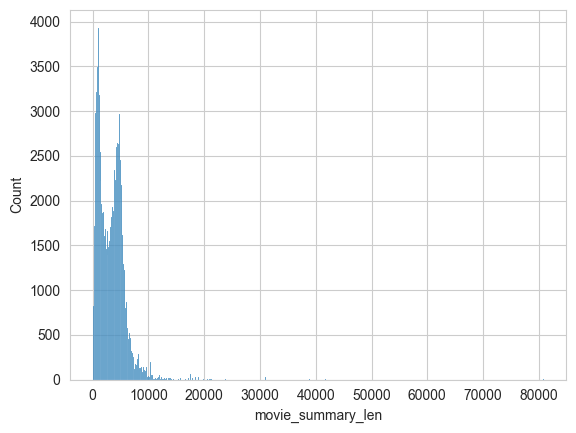

In [6]:
import seaborn as sns

sns.set_style('whitegrid')
sns.histplot(df_for_inference.movie_summary_len)
print((df_for_inference.movie_summary_len > 8000).sum())

In [7]:
df_for_inference = df_for_inference[df_for_inference.movie_summary_len < 8000]
len(df_for_inference)

84720

In [8]:
from langchain_core.rate_limiters import InMemoryRateLimiter
from src.models.persona_identification import PersonaIdentification
from langchain.cache import InMemoryCache
from langchain.globals import set_llm_cache
from langchain_redis import RedisCache
from tqdm.notebook import tqdm

def do_batch(cur_batch):

    cache = RedisCache(redis_url="redis://redislabs-rejson.sliplane.app:6379")
    set_llm_cache(cache)

    rate_limiter = InMemoryRateLimiter(
        requests_per_second=10 / 60,
        check_every_n_seconds=0.1,
        max_bucket_size=3,
    )

    pi = PersonaIdentification(
        config_path="../../src/models/persona_identification_config.yaml",
        cache=cache,
        rate_limiter=rate_limiter
    )


    batch_res = pi.batch(cur_batch.to_dict(orient="records"))
    cur_batch['model_prediction'] = [res.content for res in batch_res]
    cur_batch["is_prediction_valid"] = [1 if res.response_metadata["parsing_success"] else 0 for res in batch_res]

    if cur_batch.is_prediction_valid.mean() < 0.5:
        print("too many fails")

    return cur_batch



result = None

BATCH_SIZE = 80
for i in tqdm(range(0, len(df_for_inference), BATCH_SIZE)):
    cur_batch = df_for_inference.iloc[i:i+BATCH_SIZE]
    cur_batch = do_batch(cur_batch)
    if result is None:
        result = cur_batch
    else:
        result = pd.concat([result, cur_batch])
    
    result.to_csv('archetype_inference_dump.csv')

  0%|          | 0/1059 [00:00<?, ?it/s]

/var/folders/d_/x1jfcqpx1cl4zcrx9bzpclq00000gn/T/ipykernel_25811/4283665246.py:13: LangChainBetaWarning: Introduced in 0.2.24. API subject to change.
  rate_limiter = InMemoryRateLimiter(
/var/folders/d_/x1jfcqpx1cl4zcrx9bzpclq00000gn/T/ipykernel_25811/4283665246.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_batch['model_prediction'] = [res.content for res in batch_res]
/var/folders/d_/x1jfcqpx1cl4zcrx9bzpclq00000gn/T/ipykernel_25811/4283665246.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

KeyboardInterrupt: 